In [58]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
using Reel
#using POMDPs
#using POMDPSimulators
#using POMDPPolicies
#using POMDPModelTools
using GridInterpolations
using DataStructures
using DataFrames
using CSV

In [84]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual.jl")
rng = MersenneTwister(2);
#

In [19]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng, qual)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd, qual)::NTuple{5, Real}
end
#

f (generic function with 2 methods)

In [20]:
function r(s::NTuple{5,Real})
    range = s[1]
    if range > 150 return -.1 end  # reward to not lose track of contact
    if range <= 10 return -1 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 2 methods)

In [21]:
angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [22]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [89]:
totals = [0.0]
#θ = zeros(length(grid),6);
θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [96]:

N = 500
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.5
γ = 0.7
ϵ = .2
x = [20, 60, 90, 1, 1];
λ = 0.8
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [100]:
## Q-learning loop
plots = []
betas = Deque{Array}()
β = zeros(length(grid),6);

epochs = 1000
last = 0

total = 0
ξ = weighted_grid_2(b)/N
for i in 1:(1500*epochs)
    counter += 1
    
    
    # choose next action
    u = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = weighted_grid_2(b)/N
    β[:,u] = ξ
       
    total += rew
    #v = 10^3*sqrt(var(ξ))
    if length(betas) < 20
        pushfirst!(betas, β)
    else
        pop!(betas)
        pushfirst!(betas, β)
    end
    
    cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng) - last)
    #println(cur)
    
    #update θ
    #θ += α * cur *β
    for (j, bet) in enumerate(betas)
        θ += (λ^j) * α * cur * bet
    end
    
    
    last = transpose(θ[:,u])*ξ
    if counter % 1500 == 0
        push!(totals, total/2)
        #ϵ = max(min((20000 - 2*total)/180000, 1), 0)
        println("--------- CURRENT: ", total/2, " AVG: ", mean(totals), " Epoch: ", 
            trunc(Int, counter/500), " -----------")
        total = 0
        xp = [rand(rng, 25:120), rand(rng,0:360), rand(rng,0:11)*30, 1, 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        last = 0
        sleep(3)
    end
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: -67.89999999999829 AVG: 15.240433212996498 Epoch: 909 -----------
--------- CURRENT: -29.600000000000286 AVG: 15.18653846153857 Epoch: 912 -----------
--------- CURRENT: -62.1999999999986 AVG: 15.093637454982103 Epoch: 915 -----------
--------- CURRENT: -26.100000000000236 AVG: 15.044244604316653 Epoch: 918 -----------
--------- CURRENT: -49.34999999999933 AVG: 14.967125748503102 Epoch: 921 -----------
--------- CURRENT: -60.59999999999871 AVG: 14.876734449760875 Epoch: 924 -----------
--------- CURRENT: -51.49999999999921 AVG: 14.797431302270121 Epoch: 927 -----------
--------- CURRENT: 10.100000000000009 AVG: 14.791825775656434 Epoch: 930 -----------
--------- CURRENT: -46.3999999999995 AVG: 14.718891537544806 Epoch: 933 -----------
--------- CURRENT: -57.19999999999889 AVG: 14.63327380952392 Epoch: 936 -----------
--------- CURRENT: -39.49999999999989 AVG: 14.568906064209386 Epoch: 939 -----------
--------- CURRENT: -56.29999999999894 AVG: 14.484738717339779 Epoch

--------- CURRENT: 26.550000000000285 AVG: 10.323085221143621 Epoch: 1197 -----------
--------- CURRENT: -36.80000000000005 AVG: 10.272306034482906 Epoch: 1200 -----------
--------- CURRENT: -33.20000000000026 AVG: 10.225511302475928 Epoch: 1203 -----------
--------- CURRENT: -48.99999999999935 AVG: 10.161827956989391 Epoch: 1206 -----------
--------- CURRENT: -17.800000000000118 AVG: 10.13179377013978 Epoch: 1209 -----------
--------- CURRENT: 0.10000000000000032 AVG: 10.121030042918601 Epoch: 1212 -----------
--------- CURRENT: -22.400000000000126 AVG: 10.08617363344066 Epoch: 1215 -----------
--------- CURRENT: -10.10000000000001 AVG: 10.064561027837405 Epoch: 1218 -----------
--------- CURRENT: 55.59999999999898 AVG: 10.113262032085705 Epoch: 1221 -----------
--------- CURRENT: 51.249999999999126 AVG: 10.157211538461683 Epoch: 1224 -----------
--------- CURRENT: -23.700000000000202 AVG: 10.121077908217858 Epoch: 1227 -----------
--------- CURRENT: 16.900000000000105 AVG: 10.1283049

InterruptException: InterruptException:

In [65]:
var([2, 3, 4])

1.0

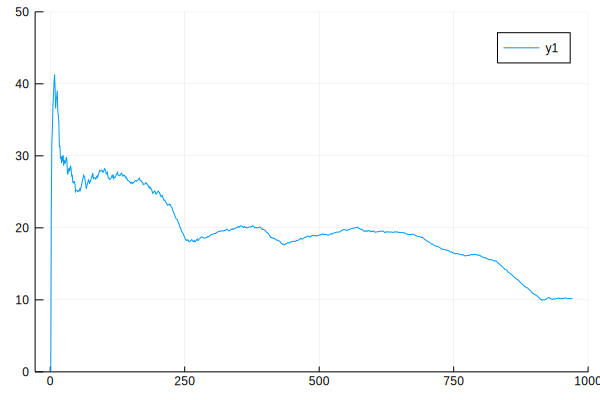

In [101]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (0,50))

2.0131182926706272e35

In [102]:
thetaframe = DataFrame(θ)
CSV.write("0.43_theta_11.26_1", thetaframe)

"0.43_theta_11.26_1"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5